## Maryam Vazirabad
## Final Project : Building a CNN model and training it on skin-cancer dataset (categorizing images)
## 11/22/2019
### Using Skin Cancer MNIST: HAM10000 Dataset found here: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
### This dataset contains approximately 10,000 different images of skin lesions and has seven categories of images (for each type of skin lesion we are attempting to classify) and are about 600x450 pixels. This is a huge dataset in terms of number of images so I hope I can develop a robust model.


#### First, we import the necessary libraries:

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical 
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
np.random.seed(101)

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

## Processing the data:

#### Next, we load the data, merging images from folders into one dictionary
#### Used glob to get the path of each image (got help from stackoverflow: https://stackoverflow.com/questions/51434091/python-globbing-a-directory-of-images). The key of the dictionary will be each image name and the value the relative path to that image (type of lesion) 
#### The dictionary will help us with the one-hot encoding

In [2]:
files = '../input'
image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(files, '*', '*.jpg'))}

#### the meta data file contains the information about skin lesions and the patients:

In [3]:
skind = pd.read_csv(os.path.join(files, 'HAM10000_metadata.csv'))
skind.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [4]:
skind['image_path'] = skind['image_id'].map(image_paths.get)

#### Seven categories of skin diagnoses:
#### 1. Actinic Keratoses (squamous cell carcinoma) and Intraepithelial Carcinoma (Bowen’s disease)
#### 2. Basal cell carcinoma
#### 3. Benign keratosis
#### 4. Dermatofibroma
#### 5. Melanocytic nevi
#### 6. Melanoma

#### Key of dictionary is the shorthand name of the lesion and the actual type of lesion is the value of key
#### Information about the shorthand for each diagnosis found in this article: https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

In [5]:
diagnoses = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}
skind['type'] = skind['dx'].map(diagnoses.get)

#### Converting the type to the categorical values for one hot encoding, then viewing dataset. No columns, particularly image_path, appear to be null so this is good:

In [6]:
skind['type_id'] = pd.Categorical(skind['type']).codes
skind.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,type,type_id
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,../input/HAM10000_images_part_1/ISIC_0027850.jpg,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,../input/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,../input/HAM10000_images_part_1/ISIC_0029068.jpg,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,../input/HAM10000_images_part_1/ISIC_0025837.jpg,Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,../input/HAM10000_images_part_1/ISIC_0025209.jpg,Benign keratosis-like lesions,2


#### Need to remove null values before building CNN model (will otherwise affect performance of model). Checking where they are:

In [7]:
print(skind.isna().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
image_path       0
type             0
type_id          0
dtype: int64


#### It's a common trick to fill the null values with the average of the columns (got help from https://machinelearningmastery.com/handle-missing-data-python/) so let's do that for age:

In [8]:
skind['age'] = skind['age'].fillna(skind['age'].mean())

## Data Analysis: Exploring the data first
#### (got help with creating different plots from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

#### I'm interested in learning more about the dataset and seeing the distribution of skin diagnoses.The majority of the images belong to the class of melanocytic nevi. This shows bias, but is also realistic becuase melanocytic nevi is apparently the most common skin lesion (they are moles or birth marks)

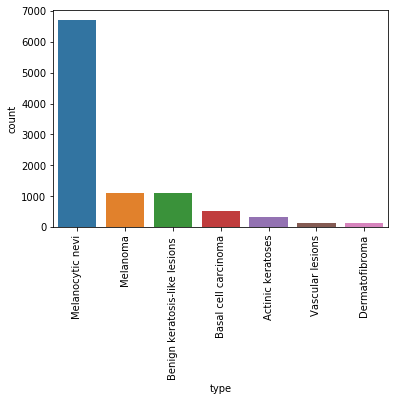

In [9]:
fig = sns.countplot(x = skind['type'],order = skind['type'].value_counts().index)
plt.xticks(fig.get_xticks(),rotation = 90)
plt.show()

#### Age distribution (middle-aged people seem to be the most affected):

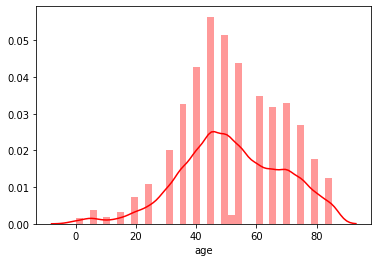

In [10]:
sns.distplot(skind['age'], color = 'red')
plt.show()

#### What types of skin lesions affect people of different ages? It appears that Actinic keratoses, Basal cell carcinoma, and Dermatofibroma affect the younger generation the least:

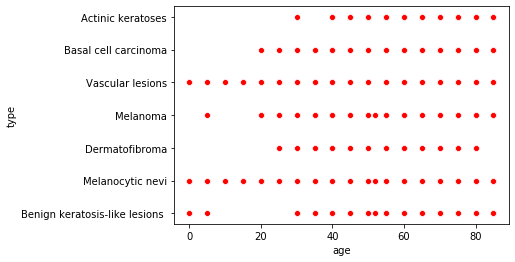

In [11]:
sns.scatterplot(skind['age'], skind['type'], color = 'red')
plt.show()

#### Gender distribution (males seem to have more skin diagnoses than women):

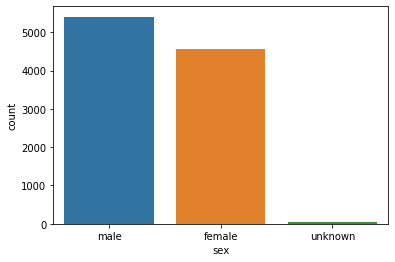

In [12]:
fig = sns.countplot(x = skind['sex'], order = skind['sex'].value_counts().index)
plt.show()

#### Relating age and gender to diagnosis. From these box plots, it doesn't appear that there is a strong link between age, gender, and skin diagnoses. It varies a lot depending on the particular diagnosis:

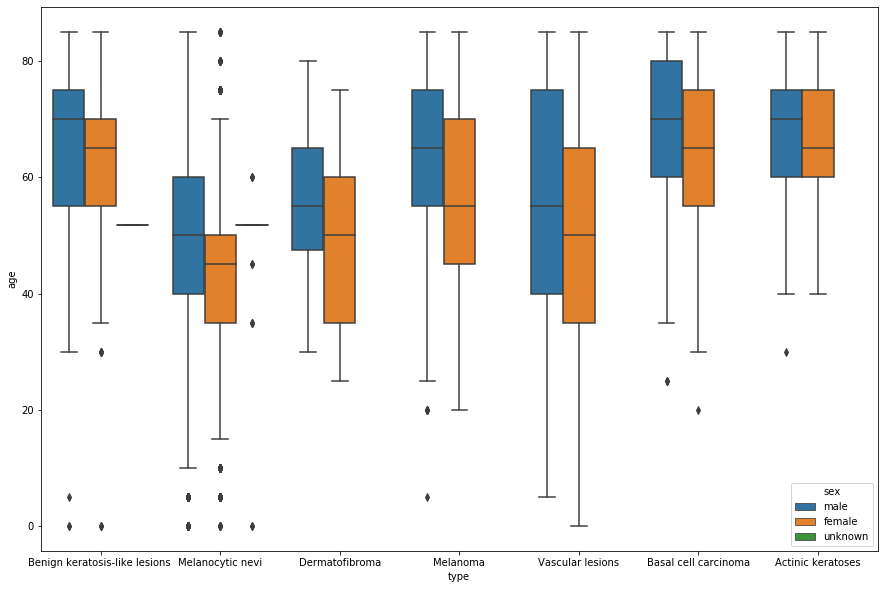

In [13]:
f, ax1 = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(x=skind['type'], y=skind['age'], hue=skind['sex'], ax=ax1)
plt.show()

#### Image resizing. We are resizing the images from 600x450 to 32x32 pixels:

In [14]:
print(np.asarray(Image.open(skind['image_path'][0]).resize((32,32)))[:4])

[[[189 149 186]
  [192 154 193]
  [199 154 185]
  [202 162 189]
  [207 168 195]
  [208 171 205]
  [210 164 200]
  [211 168 196]
  [215 171 204]
  [216 180 206]
  [219 187 211]
  [215 175 212]
  [212 166 195]
  [219 172 216]
  [214 158 195]
  [211 163 203]
  [217 173 209]
  [219 170 202]
  [219 174 205]
  [211 161 188]
  [206 159 177]
  [204 155 174]
  [205 159 188]
  [208 161 197]
  [193 141 153]
  [187 130 149]
  [191 138 156]
  [192 148 175]
  [184 133 142]
  [197 149 165]
  [197 154 161]
  [193 151 161]]

 [[199 162 203]
  [198 162 198]
  [202 161 193]
  [205 164 194]
  [205 160 189]
  [210 171 215]
  [215 167 205]
  [210 150 176]
  [207 175 214]
  [213 179 195]
  [217 181 207]
  [218 183 207]
  [216 177 206]
  [220 170 207]
  [219 166 192]
  [212 156 185]
  [213 164 186]
  [216 171 192]
  [219 164 187]
  [215 171 198]
  [206 156 181]
  [208 161 197]
  [208 160 198]
  [211 164 196]
  [197 143 166]
  [191 136 165]
  [203 153 182]
  [193 143 168]
  [184 132 144]
  [201 156 163]
  [193

In [15]:
skind['image'] = skind['image_path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

#### Showing some random images after resizing (got help witht this function from https://medium.com/towards-artificial-intelligence/image-classification-using-deep-learning-pytorch-a-case-study-with-flower-image-data-80a18554df63):

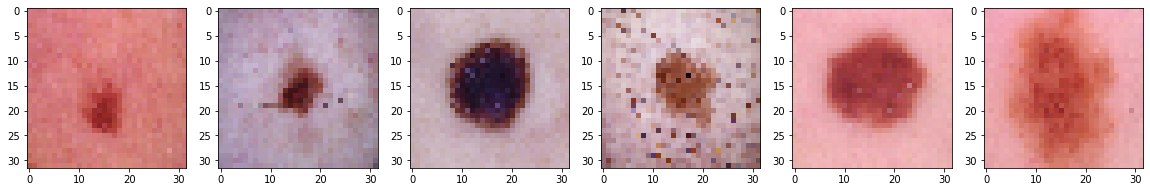

In [16]:
plt.figure(figsize= (20,10))
for i,img in enumerate(np.random.randint(0, 5000, 6)):
    plt.subplot(1,6,i+1)
    plt.imshow(skind['image'][img])
plt.show()

#### Categorizing:

In [17]:
x_ = skind.drop(columns=['type_id'],axis=1)
y = skind['type_id']

#### Time to split test and train datasets (80% for train set, 20% for test dataset):¶

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x_, y, test_size = 0.20, random_state = 42)

In [19]:
X_train = np.asarray(X_train['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

#### Converting labels:

In [20]:
y_train = to_categorical(y_train, num_classes= 7)
y_test = to_categorical(y_test, num_classes= 7)

#### Getting the shape of the X_train , y_train , X_test and y_test data:

In [21]:
print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (8012, 32, 32, 3)
y_train shape: (8012, 7)
x_test shape: (2003, 32, 32, 3)
y_test shape: (2003, 7)


#### Time to build the model. I'm going to use a basic architecture that we've used in assignment 5 to see how it works:

#### adding the first convolution layer to extract the features first
#### 3x3 relu
#### input shape 32,32,3

In [22]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',input_shape=(32,32,3)))

#### Adding dropout of .2 and creating another layer without the input_shape:

In [23]:
model.add(Dropout(.2))
model.add(Conv2D(32, (3,3), activation='relu'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Adding pooling layer with a 2x2 pixel filter to get the max element from the feature maps. Reduces the dimension of the feature maps by half

In [24]:
model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

#### Continuing with adding more neurons and dropouts:

In [25]:
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Dropout(.2))
#64 neurons
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))
#now 128 neurons
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Dropout(.2))
#128 neurons
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

#### Adding flattening layer to reduce the image to a linear array:

In [26]:
model.add(Flatten())
model.add(Dropout(.2))
#1024 neurons 
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.2))
#512 neurons
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))

#### Creating the last layer of this neural network with 7 neurons (for 7 categories) using the softmax function:

In [27]:
model.add(Dense(7, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)       

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [30]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=0.3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5608 samples, validate on 2404 samples
Epoch 1/50
5608/5608 [==============================] - 21s 4ms/step - loss: 1.1346 - acc: 0.6389 - val_loss: 1.1276 - val_acc: 0.6755
Epoch 2/50
5608/5608 [==============================] - 19s 3ms/step - loss: 0.9595 - acc: 0.6674 - val_loss: 0.9126 - val_acc: 0.6768
Epoch 3/50
5608/5608 [==============================] - 19s 3ms/step - loss: 0.8922 - acc: 0.6694 - val_loss: 0.8828 - val_acc: 0.6905
Epoch 4/50
5608/5608 [==============================] - 18s 3ms/step - loss: 0.8920 - acc: 0.6740 - val_loss: 0.8574 - val_acc: 0.6930
Epoch 5/50
5608/5608 [==============================] - 18s 3ms/step - loss: 0.8301 - acc: 0.6903 - val_loss: 0.8370 - val_acc: 0.7080
Epoch 6/50
5608/5608 [==============================] - 19s 3ms/step - loss: 0.8150 - acc: 0.6953 - val_loss: 0.9022 - val_acc: 0.6843
Epoch 7/50
5608/5608 [==========================

#### The accuracy of the model resulted to be about 70%

In [31]:
model.evaluate(X_test, y_test)

2003/2003 [==============================] - 2s 903us/step


[1.1115208771368057, 0.7289066399506671]

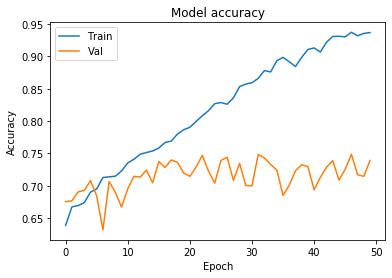

In [33]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

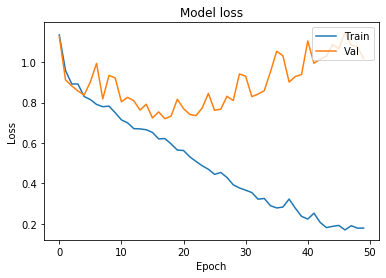

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### The model used on the skin dataset didn't end up working as well as I had hoped. After running 50 epochs, the accuracy came to be about 69.5%.The model's loss came to be around .8 after 50 epochs. The training sets came out to be a lot higher in accuracy than with validation. This means that my data has been overfitted, which is interesting given how large the dataset is.
### I want to get my accuracy higher than 70. I decided to change my model architecture to see if that would help the overfitting. Attempting to do this by reducing the number of layers:

#### Adding the first convolution layer to extract the features first
#### 3x3 relu and input shape 32,32,3
#### And then create another layer without the input_shape:

In [35]:
model = Sequential()
model.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'SAME', input_shape = (32, 32, 3)))
model.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'SAME'))

#### Add pooling layer with a 2x2 pixel filter to get the max element from the feature maps. Reduces the dimension of the feature maps by half. Adding dropout of .2:

In [36]:
model.add(MaxPool2D(pool_size= (2, 2)))
model.add(Dropout(0.25))

#### 64 neurons in next two layers, adding pooling layer with 2x2 pixel filter and adding dropout of .4:

In [37]:
model.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'SAME'))
model.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'SAME'))
model.add(MaxPool2D(pool_size= (2, 2)))
model.add(Dropout(0.4))

#### Adding flattening layer to reduce the image to a linear array, and then using 128 neurons in next layer. Adding dropout of 0.5:

In [38]:
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dropout(0.5))

#### Create the last layer of this neural network with 7 neurons using the softmax function

In [39]:
model.add(Dense(7, activation= 'softmax'))

#### Model summary. Shows that there are a lot less parameters in this model compared to the last one I tried:

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)         

#### Compile model with specific loss function, optimizier, and accuracy metrics. For loss, categorical_cross-entropy :

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#### 

In [42]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=0.3)

Train on 5608 samples, validate on 2404 samples
Epoch 1/50
5608/5608 [==============================] - 26s 5ms/step - loss: 1.1476 - acc: 0.6396 - val_loss: 0.9821 - val_acc: 0.6801
Epoch 2/50
5608/5608 [==============================] - 23s 4ms/step - loss: 0.9431 - acc: 0.6692 - val_loss: 0.9237 - val_acc: 0.6826
Epoch 3/50
5608/5608 [==============================] - 27s 5ms/step - loss: 0.8866 - acc: 0.6714 - val_loss: 0.8698 - val_acc: 0.6947
Epoch 4/50
5608/5608 [==============================] - 27s 5ms/step - loss: 0.8719 - acc: 0.6871 - val_loss: 0.8415 - val_acc: 0.6980
Epoch 5/50
5608/5608 [==============================] - 25s 4ms/step - loss: 0.8424 - acc: 0.6878 - val_loss: 0.8150 - val_acc: 0.7013
Epoch 6/50
5608/5608 [==============================] - 25s 4ms/step - loss: 0.8192 - acc: 0.7042 - val_loss: 0.8006 - val_acc: 0.7076
Epoch 7/50
5608/5608 [==============================] - 23s 4ms/step - loss: 0.7990 - acc: 0.7049 - val_loss: 0.7762 - val_acc: 0.7209
Epoch 8

#### Evaluating the model:¶

In [43]:
model.evaluate(X_test, y_test)

2003/2003 [==============================] - 2s 1ms/step


[0.9139405119377437, 0.7483774341170454]

#### Plotting model accuracy to the number of epochs:

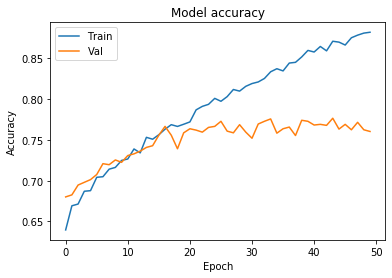

In [44]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### Plotting the model loss to the number of epochs:

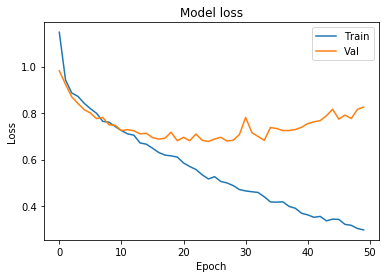

In [45]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### The model used on the skin dataset came out to be relatively accurate. After running 50 epochs, the accuracy came to be about 75%. The model's loss came to be around .75 after 50 epochs as well. This model is an improvement to the last one, which gave an accuracy score of 69% for the validation set. 
### I definitely think reducing the number of layers helped with improving the performance of the model. I did try to increase the size of the images to larger than 32x32 pixels to see if this was having an impact on the performance of the model and if the more detailed images would increase my accuracy, but it did not show an improvement.